In [129]:
from IPython.display import clear_output

In [130]:
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv, toeplitz
from scipy import fft
from tqdm import tqdm, trange

In [131]:
import torch
from torch.nn.functional import relu, mse_loss, conv1d
from torch.nn import Module, ReLU

device = torch.device('cuda')
print(device)

cuda


In [132]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples, sig=0.0, A=None):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            print("{}/{}".format(ii, Nexamples))
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X).reshape(Nexamples, N)
        print(self.X.shape)
        self.Y = self.X @ A.T
        print(self.Y.shape)
    
    def __getitem__(self, i):
        return (self.X[i, ...], self.Y[i, ...])
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x

In [134]:
# Create training data
maxit = 10
M = 64
N = 512
sig = 0.4
epochs = 10
batchSize = 20
testFreq = 1
trainingPoints = 10_000
testingPoints = 100
sparsityLevel = 5

# Create ULA and Nested Array Matricies
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints, A=A_u)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints, A=A_u)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = testingPoints, shuffle=False)
batches = int(trainingPoints/batchSize)
print(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

Streaming output truncated to the last 5000 lines.
5105/10000
5106/10000
5107/10000
5108/10000
5109/10000
5110/10000
5111/10000
5112/10000
5113/10000
5114/10000
5115/10000
5116/10000
5117/10000
5118/10000
5119/10000
5120/10000
5121/10000
5122/10000
5123/10000
5124/10000
5125/10000
5126/10000
5127/10000
5128/10000
5129/10000
5130/10000
5131/10000
5132/10000
5133/10000
5134/10000
5135/10000
5136/10000
5137/10000
5138/10000
5139/10000
5140/10000
5141/10000
5142/10000
5143/10000
5144/10000
5145/10000
5146/10000
5147/10000
5148/10000
5149/10000
5150/10000
5151/10000
5152/10000
5153/10000
5154/10000
5155/10000
5156/10000
5157/10000
5158/10000
5159/10000
5160/10000
5161/10000
5162/10000
5163/10000
5164/10000
5165/10000
5166/10000
5167/10000
5168/10000
5169/10000
5170/10000
5171/10000
5172/10000
5173/10000
5174/10000
5175/10000
5176/10000
5177/10000
5178/10000
5179/10000
5180/10000
5181/10000
5182/10000
5183/10000
5184/10000
5185/10000
5186/10000
5187/10000
5188/10000
5189/10000
5190/10000
519

In [135]:
torch.save(dataset_training, "training_data.pt")
torch.save(dataset_testing, "testing_data.pt")

In [136]:
class ComplexLISTA(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wrg = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wig = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        #self.alpha = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        #self.lamda = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
        Wrgt = torch.transpose(self.Wrg[0], 0, 1)
        Wigt = torch.transpose(self.Wig[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[0])

        #soft = torch.divide(self.theta[0], self.theta[0])
        #soft = torch.divide(self.theta[0], torch.max(xabs, self.theta[0]))
        #soft = 1 - torch.divide(self.theta[0], relu(xabs - self.theta[0]) + self.theta[0]) 
        #soft = 1 - torch.divide(self.theta[0], self.relu(xabs - self.theta[0]) + self.theta[0]) 
        #xr = torch.multiply(zr, softr)
        #xi = torch.multiply(zi,  softi)
        
        
        for t in range(1, self.maxit+1):
            
            Wret = torch.transpose(self.Wre[0], 0, 1)
            Wiet = torch.transpose(self.Wie[0], 0, 1)
            Wrgt = torch.transpose(self.Wrg[0], 0, 1)
            Wigt = torch.transpose(self.Wig[0], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply Wg branch to x^(t) for t-th iteration
            br = torch.matmul(xr, Wrgt) - torch.matmul(xi, Wigt)
            bi = torch.matmul(xi, Wrgt) + torch.matmul(xr, Wigt)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            #xr = zr * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            #xi = zi * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[t])
            #soft = torch.divide(self.theta[t], self.theta[t]) 
            #soft = torch.divide(self.theta[t], torch.max(xabs, self.theta[t]))
            #soft = 1 - torch.divide(self.theta[t], self.relu(xabs - self.theta[t]) + self.theta[t]) 
            #soft = 1
            #xr = torch.multiply(zr, softr)
            #xi = torch.multiply(zi, softi)
            
            #print(f"{yr[0,0] = }, {zr[0,0] = }, {xr[0,0] = }, {self.theta[0] = }, {soft[0,0] = }, {self.Wre[0,0] = }, {self.Wrg[0,0] = }")
      
        return xr, xi

In [137]:
class ComplexLISTA_Toeplitz(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA_Toeplitz, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.hrg = torch.nn.Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True) # dimension such that it works with conv1d
        self.hig = torch.nn.Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        #self.alpha = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        #self.lamda = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[0])

        #soft = torch.divide(self.theta[0], self.theta[0])
        #soft = torch.divide(self.theta[0], torch.max(xabs, self.theta[0]))
        #soft = 1 - torch.divide(self.theta[0], relu(xabs - self.theta[0]) + self.theta[0]) 
        #soft = 1 - torch.divide(self.theta[0], self.relu(xabs - self.theta[0]) + self.theta[0]) 
        #xr = torch.multiply(zr, softr)
        #xi = torch.multiply(zi,  softi)
        
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
            hrgt = self.hrg[t]
            higt = self.hig[t]
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')
            
            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            #xr = zr * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            #xi = zi * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[t])
            #soft = torch.divide(self.theta[t], self.theta[t]) 
            #soft = torch.divide(self.theta[t], torch.max(xabs, self.theta[t]))
            #soft = 1 - torch.divide(self.theta[t], self.relu(xabs - self.theta[t]) + self.theta[t]) 
            #soft = 1
            #xr = torch.multiply(zr, softr)
            #xi = torch.multiply(zi, softi)
            
            #print(f"{yr[0,0] = }, {zr[0,0] = }, {xr[0,0] = }, {self.theta[0] = }, {soft[0,0] = }, {self.Wre[0,0] = }, {self.Wrg[0,0] = }")
      
        return xr, xi

In [138]:
model = ComplexLISTA_Toeplitz(M, N, maxit)

# for name, weights in model.named_parameters():
#     print(name, weights)
print(model.state_dict())

OrderedDict([('Wre', tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
 

In [139]:
# Initialize Wg matrix according to Eldar
X, Y = dataset_training[:100]
print(X.shape, Y.shape)
X = X.numpy().T
Y = Y.numpy().T
XHX = X.T.conj() @ X 
XHXinv = pinv(XHX)
Phi = Y @ XHXinv @ X.T.conj() # conjugates omitted since X will be real
PhiH = torch.from_numpy(Phi.conj().T)
L = np.max(np.abs(np.linalg.eigvals(Phi.conj().T @ Phi)))

#print(model.state_dict()['Wre'])
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'Wre' in name:
            param.copy_(1/L * PhiH.real)
        if 'Wie' in name:
            param.copy_(1/L * PhiH.imag)
        if 'theta' in name:
            param.copy_(0.01/L * torch.ones(model.maxit+1))

print(model.state_dict()['Wre'][0])
print(model.state_dict()['Wre'][-1])

torch.Size([100, 512]) torch.Size([100, 64])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0047,  0.0023,  0.0005,  ...,  0.0002,  0.0027,  0.0019],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0025, -0.0005,  0.0006,  ..., -0.0008, -0.0009,  0.0003],
        [ 0.0011,  0.0022,  0.0010,  ...,  0.0007,  0.0003, -0.0009],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0047,  0.0023,  0.0005,  ...,  0.0002,  0.0027,  0.0019],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0025, -0.0005,  0.0006,  ..., -0.0008, -0.0009,  0.0003],
        [ 0.0011,  0.0022,  0.0010,  ...,  0.0007,  0.0003, -0.0009],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
obj = torch.nn.MSELoss()
t = trange(epochs)
for e in t:
    for i, data in enumerate(dataloader_training):

        idx = e * batches + i
        x, y = data
        
        # Split data to real and complex
        xr = x.to(torch.float32)
        xi = torch.zeros_like(xr).to(torch.float32)
        
        yr = y.real.to(torch.float32)
        yi = y.imag.to(torch.float32)
        
        # Send through model
        xpredr, xpredi = model(yr, yi)
        
        loss = obj(xpredr, xr) + obj(xpredi, xi)

        with torch.no_grad():
            training_losslist[idx] = loss

        loss.backward()    
        optim.step()
        optim.zero_grad()
        
        if testFreq and idx % testFreq == 0:
            for k, test_data in enumerate(dataloader_testing):
                
                x, y = test_data
                
                xr = x.to(torch.float32)
                xi = torch.zeros_like(xr).to(torch.float32)
                
                yr = y.real.to(torch.float32)
                yi = y.imag.to(torch.float32)
                
                xpredr, xpredi = model(yr, yi)
                xpredr = xpredr.detach().cpu()
                xpredi = xpredi.detach().cpu()

                testing_losslist[idx] += torch.mean((xpredr.cpu() - xr.cpu())**2) + torch.mean((xpredi.cpu() - xi.cpu())**2)

        t.set_description("Batch: {}/{}\t Training Loss: {}\t Validation Loss: {}".format(i, len(dataloader_training), training_losslist[idx], testing_losslist[idx]), refresh=True)

        #clear_output(wait=True)
        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t Validation Loss: {}".format(e, i, training_losslist[idx], testing_losslist[idx]))

        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t".format(e, i, training_losslist[idx]), end='\r')

Batch: 12/500	 Training Loss: 0.009681599214673042	 Validation Loss: 0.009685050696134567:   0%|          | 0/10 [00:31<?, ?it/s]

In [ ]:
print(training_losslist[0])
plt.plot(training_losslist)
plt.plot(testing_losslist)
torch.save(model.state_dict(), "model_weights.pt")

In [ ]:
# ''' Manually Set Values for Normal ISTA '''
# model_ista = ComplexLISTA(M, N, 1)
# L = np.max(np.abs(np.linalg.eigvals(A_u.conj().T @ A_u)))
# lambb = 1
# P = A_u.conj().T @ A_u
# We = 1/L * A_u.conj().T
# Wg = (np.eye(P.shape[0]) - 1/L * P)
# with torch.no_grad():
#     for name, param in model_ista.named_parameters():
#         if 'Wre' in name:
#             param.copy_(1/L * torch.from_numpy(We.real))
#         if 'Wie' in name:
#             param.copy_(1/L * torch.from_numpy(We.imag))
#         if 'Wrg' in name:
#             param.copy_(1/L * torch.from_numpy(Wg.real))
#         if 'Wig' in name:
#             param.copy_(1/L * torch.from_numpy(Wg.imag))
#         if 'theta' in name:
#             param.copy_(lambb/L * torch.ones(model_ista.maxit+1))
            
# print(model_ista.state_dict())


In [ ]:
x_test, y_test = dataset_testing[2]

yr = y_test.real.to(torch.float32)
yi = y_test.imag.to(torch.float32)

model.eval()
xpredr, xpredi = model(yr, yi)
# xistar, xistai = model_ista(yr, yi)

x_test = x_test.numpy()
x_pred = np.zeros_like(x_test, dtype=complex)
x_pred.real = xpredr.detach().numpy()
x_pred.imag = xpredi.detach().numpy()

# x_ista = np.zeros_like(x_test, dtype=complex)
# x_ista.real = xistar.detach().numpy()
# x_ista.imag = xistai.detach().numpy()

S_test = np.abs(x_test)
S_pred = np.abs(x_pred)
# S_ista = np.abs(x_ista)

S_test /= S_test.max()
S_pred /= S_pred.max()
# S_ista /= S_ista.max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


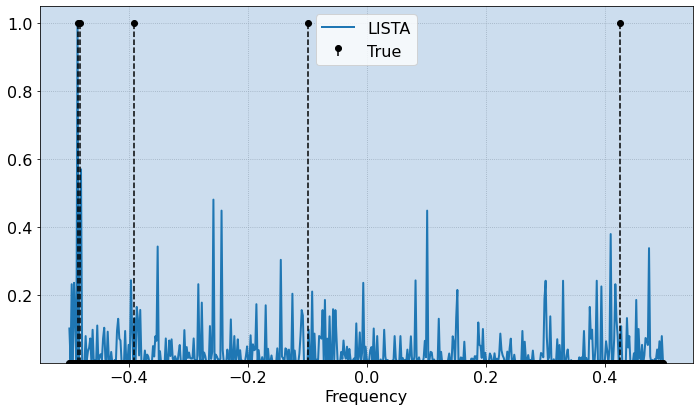

In [ ]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred), linewidth=2, label='LISTA')
#ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_ista), linewidth=2, label='ISTA')
ax.stem(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_test), 'k', markerfmt='ko', linefmt='k--', label='True',  basefmt=" ")
y1, y2 = ax.get_ylim()
#ax.vlines(fft.fftshift(fft.fftfreq(N)[np.nonzero(S_test)]), linestyle='--', ymin=0, ymax=y2, color='k', label='True')
ax.set_ylim(0.001, y2)
ax.set_xlabel('Frequency')
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()

In [21]:
Nn = 103
abcd = torch.arange(Nn).reshape(1, 1, -1)
efgh = torch.arange(Nn).reshape(1, 1, -1)
xxxx = conv1d(abcd, efgh, padding=Nn//2)
print(xxxx.shape)

torch.Size([1, 1, 103])


In [94]:
wxyz = np.array([1, 2, 3])
stuv = np.array([4, 5, 6])
T = toeplitz(np.hstack([np.flip(stuv[:-1]), 0]), r=np.hstack([stuv[1:], 0]))
print(stuv[1:])
print(stuv[:-1])
print(T @ wxyz)
print(T)

[5 6]
[4 5]
[17 32 23]
[[5 6 0]
 [4 5 6]
 [0 4 5]]


In [98]:
ijkl = torch.randn(100, 2).unsqueeze(1)
print(ijkl.shape)

torch.Size([100, 1, 2])
